# Zombies and Covid-19 - Trust the models, or your gut?

## Computational Engineering and Modelling Project 3 
 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import optimize as opt

%matplotlib inline

In [137]:
class ODESolver:
    """
    Base class for ODE solvers.
    Subclasses of this class will implement a particular numerical
    scheme for solving a system of first-order ODEs of the form

        dY/dt = f(Y, t), Y(0)=Y0,

    where Y=Y(t) can be either a function of a single real-valued
    variable, or a vector of such functions.

    Note that the current implementation presumes a constant step
    size for the integration. This assumption will of course have
    to be relaxed if adaptive step size control is to be used.
    """

    def __init__(self, f, y0, dt):
        """
        :param f: The right-hand side function of the ODE (system).
        :param y0: The initial condition.
        :param dt: Constant step size.
        """
        # Trick: Ensure that f will return an array even if the
        # user returns a list
        self.f_ = lambda y, t: np.array(f(y, t), dtype='float')
        self.y0_ = y0
        self.dt_ = dt

        # Set simulation history to "None" before initializing
        self.t_ = None
        self.y_ = None

    def reset_model(self):
        """
        Resets the model before starting up a new simulation.
        """
        self.t_ = [0]
        self.y_ = [self.y0_]

    def solve(self, max_t, verbose=0):

        self.reset_model()

        no_steps = int(max_t / self.dt_)

        current_t = 0
        dt = self.dt_
        for _ in range(no_steps):
            self.advance(dt)
            current_t += dt
            if verbose:
                msg = 'Done computing solution at'
                msg += ' t={}.'.format(current_t)
                print(msg)
        return np.array(self.t_), np.array(self.y_)

    def advance(self, dt):
        err = "advance() cannot be called on base class ODESolver."
        err += " Must call on an instance of an ODESolver subclass!"
        raise NotImplementedError(err)

class ForwardEuler(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        self.y_.append(yn + dt * f(yn, tn))

    

    
class RungeKutta4(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        
        k_1 = dt*f(yn,tn)
        k_2 = dt*f(yn+ .5*k_1, tn + dt/2)
        k_3 = dt*f(yn + .5*k_2, tn + dt/2)
        k_4 = dt*f(yn + k_3, tn + dt)

        self.y_.append(yn + (1/6)*(k_1+2*k_2+2*k_3+ k_4))

    
class SEIRD:
    """function that takes in "filtered/combed" data, and returns derivatives of the SEIRD model """

    def __init__(self, N=58.5e6, sigma=1/5.1, gamma = 1/20, death_rate =0.05):
        self.N = N 
        #lambda_par 
        #beta0 
        self.sigma = sigma
        self.gamma = gamma
        self.death_rate = death_rate
    
    def dSEIRD_setup(self,beta0, lambda_par):
       self.beta0 = beta0
       self.lambda_par = lambda_par
       return(self.dSEIRD)
       
    def dSEIRD(self,y, t):
        beta = self.beta0*np.exp(- t*self.lambda_par)
        dS = -(beta/self.N)*y[0]*y[2]
        dE = - dS - self.sigma*y[1] 
        dI = self.sigma*y[1] - self.gamma*y[2]
        dR = (1- self.death_rate)*self.gamma*y[2]
        dD = self.death_rate*self.gamma*y[2]
        return np.array([dS,dE,dI,dR,dD])



## Exercise 1: General ODE Solver


### Part 1

In [3]:
def some_non_lin(x,y):
    return x**2 - np.exp(y) + 2*y

In [4]:
y_0 = 0
dt = 0.1
test1 = RungeKutta4(some_non_lin, y_0, dt)
test2 = ForwardEuler(some_non_lin,y_0, dt)
test1.solve(max_t=2)
test2.solve(max_t=2)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 array([ 0.        , -0.1       , -0.18951709, -0.26806569, -0.33586565,
        -0.39376755, -0.44313439, -0.48570946, -0.52349336, -0.55864293,
        -0.59339504, -0.63001146, -0.67073662, -0.71775955, -0.77317134,
        -0.83891194, -0.91670353, -1.00797223, -1.11376617, -1.23468341,
        -1.37082854]))

In this exercise we implement numerical solutions to equations of the form:
$$
\begin{align}
\tag{1}
\frac{d\mathbf{y}}{dt} &= \mathbf{f}(\mathbf{y}, t) \,, \\ 
\mathbf{y}(0) &= \mathbf{y_0} \,,
\tag{2}
\end{align}
$$

### The Runge-Kutta fourth order method can be summarized as:

$$
\begin{align}
k_1&=hf(y_n,t_n)\nonumber\\ 
k_2&=hf(y_n+\frac{1}{2}k_1,t_n+h/2)\nonumber\\ 
k_3&=hf(y_n+\frac{1}{2}k_2,t_n+h/2)\nonumber\\ 
k_4&=hf(y_n+k_3,t_n+h)\nonumber\\ 
\tag{3}
y_{n+1}&=y_n+\frac{1}{6}(k_1+2k_2+2k_3+k_4)
\end{align}
$$

### Part 2

To make sure that our implementation of the solver works properly, we will test out our implementation for the following ODE: 
$$
\begin{align}
\tag{4}
x^{\prime\prime}(t) + \omega^{2} x(t)=0\,,
\end{align}
$$

Where $ x_0=x(0) $ and $ v_0=x^{\prime}(0) $. We recognize this equation as a special case of the equation for simple harmonic motion. Hence, we can write out the analytical solution as:
$$
\begin{align}
x(t) = x_0 \cdot\cos(\omega t) + \frac{v_0}{\omega}\cdot\sin(\omega t)\,.
\tag{5}
\end{align}
$$

In this part, we calculate plots for differing parameter values in the analytic solution. 



Text(0, 0.5, 'function output')

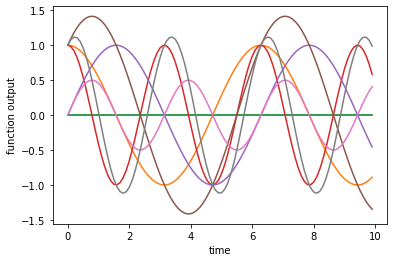

In [5]:
def harmonic_motion(t, x0,v0, w):
    return x0*np.cos(w*t) + (v0/w)*np.sin(w*t)

t = np.arange(0, 10, 0.1) 
v_list = np.arange(0, 2)
w_list = np.arange(1,3)
x0_list = np.arange(0,2)

permutes = [(x0,v0,w) for v0 in v_list for w in w_list for x0 in x0_list]

e1p2figure = plt.figure()
ax1 = e1p2figure.add_subplot()
for perm in permutes:
    ax1.plot(t, harmonic_motion(t, perm[0], perm[1],perm[2]))     #label = ('x0 ='+ str(perm[0]),'v0 =' + str(perm[1]), 'w0 =' + str(perm[2])
#e1p2figure.legend()
plt.xlabel('time')
plt.ylabel('function output')



### Part 3

This ODE is not of the first order type, and can not be directlyt solved by oru solver. We can work around this by modifying the equation.
We can think of this second order equation as a system of first order equations. first, we introduce a new variable
$ v=v(t)=x^{\prime}(t) $, and then we let: 
$$
\tag{6}
\vec{y}=
\begin{pmatrix}
x \\ 
v \\ 
\end{pmatrix}\,.
$$

We end up with:
$$
\begin{align}
\tag{7}
\frac{d\vec{y}}{dt} &=
\begin{pmatrix}
v \\ 
-\omega^2 x \\ 
\end{pmatrix} \,,
\end{align}$$


We set $v_0 = 0$, $x_0 =0 $, and $\omega = 1$ and the numeric solution:


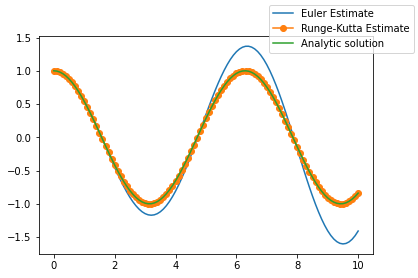

In [6]:

#Conditions 
dt = 0.1
x0 = 1
v0 = 0
y0 = (x0,v0)
w = 1
max_t = 10

def harmonic_vectorized(y_vec, dt):
    return np.array([y_vec[1],-w**2*y_vec[0]])

e1p3eulersol = ForwardEuler(harmonic_vectorized, y0, dt)
out1 = e1p3eulersol.solve(max_t)[1]
e1p3rungekutta = RungeKutta4(harmonic_vectorized, y0, dt)
out2 = e1p3rungekutta.solve(max_t)[1]


fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.plot(np.linspace(0,10,101),out1[:,0], label = 'Euler Estimate')
ax2.plot(np.linspace(0,10,101),out2[:,0], label = 'Runge-Kutta Estimate', marker ='o')
ax2.plot(np.linspace(0,10,101), harmonic_motion(np.linspace(0,10,101),1, 0,1), label = 'Analytic solution')
fig2.legend()

## Exercise 2 No hope?

### Part 1 
Show that the solution to: 

$$
\begin{align}
\tag{8}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} =-\beta\cdot\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

Similarly, the evolution of the zombie population is given by:
$$
\begin{align}
\tag{9}
\frac{\mathrm{d}Z(t)}{\mathrm{d}t} =+\beta\cdot\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

is equal to:

$$
\begin{align}
\tag{10}
S(t) &=\frac{(S_0+Z_0)\frac{S_0}{Z_0}\exp(-\beta{t})}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} \,, \\ 
\tag{11}
Z(t) &=\frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})}\,,
\end{align}
$$

where $S_0=S(0) $, $Z(0) = 1$, and $ S_0+Z_0=N $.






First, we can consider that the two equations $S(t)$ and $Z(t)$ both describe the proportion of a population N which is as either still a human or a zombie at time N. Hence, the two equations are related in the following way:  

$$
\begin{align}
\tag{13}
S(t) = N - Z(t) 
\end{align}
$$

and vice versa

$$
\begin{align}
\tag{14}
Z(t) = N - S(t) 
\end{align}
$$

Hence:

$$
\begin{align}
\tag{15}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} = - \frac{\beta}{N}S(t)(N-S(t)) 
\end{align}
$$

$$
\begin{align}
\tag{16}
\frac{\mathrm{d}S(t)}{S(t)(N-S(t))} = - \frac{\beta}{N} \mathrm{d}t 
\end{align}
$$

$$
\begin{align}
\tag{16}
\int_{S_0}^{S}\frac{\mathrm{d}S}{S(N-S)} = -\int_{0}^{t} \frac{\beta}{N} \mathrm{d}t 
\end{align}
$$

Let's try to solve the left hand side integral by partial fraction decomposition:

$$
\begin{align}
\frac{1}{S(N-S)} = \frac{A}{S} + \frac{B}{(N-S)} \rightarrow
\end{align}
$$

$$
\begin{align}
A\cdot(N-S) + B\cdot S= 1
\end{align}
$$

Here we employ the fact that this relation should hold for any value of $S(t)$, hence we get the values for A and B when $S = 0$ and $S = N$ :

$$
\begin{align}
A = B = \frac{1}{N}
\end{align}
$$


The left hand side integral can hence be written out as: 
$$
\begin{align}
\int_{S_0}^{S}( \frac{1}{NS} + \frac{1}{N(N-S)})\mathrm{d}S   = \frac{1}{N }\int_{S_0}^{S}( \frac{1}{S} + \frac{1}{N-S})\mathrm{d}S
\end{align}
$$

Evaluating this, and the right hand side integral of equation 16, we can write:

$$
\begin{align}
\frac{1}{N}[\mathrm{ln}(S) - \mathrm{ln}(N-S)]_{S_0}^{S} = -\frac{\beta}{N}[t]_{0}^{t}
\end{align}
$$

This can be solved for $S$:

$$
\begin{align}
\frac{1}{N}[\mathrm{ln} (\frac{S}{N-S})]_{S_0}^{S} = -\frac{\beta}{N}[t]_{0}^{t}
\end{align}
$$

$$
\begin{align}
\frac{1}{N} \mathrm{ln} (\frac{S(N-S_0)}{(N-S)S_0}) = -\frac{\beta}{N}t
\end{align}
$$

$$
\begin{align}
\frac{S}{(N-S)} = \frac{S_0}{N-S_0}\cdot e^{-\beta t}
\end{align}
$$

Recall that $N-S_0 = Z_0$. This means that:
$$
\begin{align}
\frac{S_0}{N- S_0} = \frac{S_0}{Z_0}
\end{align}
$$

We then get:

$$
\begin{align}
S \cdot (\frac{S_0}{Z_0}\cdot e^{-\beta t})= N \frac{S_0}{Z_0}\cdot e^{-\beta t}
\end{align}
$$

$$
\begin{align}
S = \frac{N \frac{S_0}{Z_0}\cdot e^{-\beta t}}{1+\frac{S_0}{Z_0}\cdot e^{-\beta t}}
\end{align}
$$

$$
\begin{align}
S(t) = \frac{(S_0 +Z_0) \frac{S_0}{Z_0}\cdot e^{-\beta t}}{1+\frac{S_0}{Z_0}\cdot e^{-\beta t}}
\end{align}
$$



By repeating the same process we can write out equation (9) as: 


$$
\begin{align}
\frac{\mathrm{d}Z(t)}{\mathrm{d}t} = \beta\cdot\frac{Z(t)(1-Z(t))}{N} 
\end{align}
$$

$$
\begin{align}
\int_{Z_0}^{Z}\frac{\mathrm{d}Z}{Z(1-Z)} = \int_{0}^{t} \frac{\beta}{N} \mathrm{d}t
\end{align}
$$

Again, we utlilize the same partial fraction decomposition: 
$$
\begin{align}
\frac{1}{N}  \int_{Z_0}^{Z}  \frac{1}{Z} +\frac{1}{1-Z} {\mathrm{d}Z} = \int_{0}^{t} \frac{\beta}{N} \mathrm{d}t \rightarrow
\end{align}
$$

$$
\begin{align}
\frac{1}{N} \mathrm{ln} (\frac{Z(N-Z_0)}{(N-Z)Z_0}) = \frac{\beta}{N}t
\end{align}
$$


$$
\begin{align}
\frac{Z(N-Z_0)}{(N-Z)Z_0} = e^{\beta t}
\end{align}
$$


$$
\begin{align}
 \frac{Z}{N-Z}= \frac{Z_0}{N-Z_0} e^{\beta t}
\end{align}
$$

$$
\begin{align}
Z(1 + \frac{Z_0}{N-Z_0} e^{\beta t}) = N \frac{Z_0}{N-Z_0} e^{\beta t}
\end{align}
$$

$$
\begin{align}
$$
\begin{align}
Z = N \frac{Z_0}{S_0} \frac{e^{\beta t}}{(1+ \frac{Z_0}{S_0} e^{\beta t})} | \cdot \frac{ \frac{S_0}{Z_0} e^{-\beta t}}{\frac{S_0}{Z_0}e^{-\beta t}} \rightarrow
\end{align}


$$
\begin{align}
Z(t) &=\frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})}\,,
\end{align}
$$

### Part 2

Consider the limits as t goes to infinity for both functions:

$$
\begin{align}
\mathrm{lim}_{t \rightarrow \infty} S(t) = \mathrm{lim}_{t \rightarrow \infty}  \frac{(S_0+Z_0)\frac{S_0}{Z_0}\exp(-\beta{t})}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} -\rightarrow   \frac{(S_0 +Z_0)\frac{S_0}{Z_0}\cdot e^{-\infty}}{1+\frac{S_0}{Z_0}\cdot e^{-\infty}} = \frac{0}{1} = 0
\end{align}
$$

$$
\begin{align}
\mathrm{lim}_{t \rightarrow \infty} Z(t) = \mathrm{lim}_{t \rightarrow \infty}  \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} \rightarrow \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-{\infty})} = \frac{S_0 + Z_0}{1} = N
\end{align}
$$




### Part 3

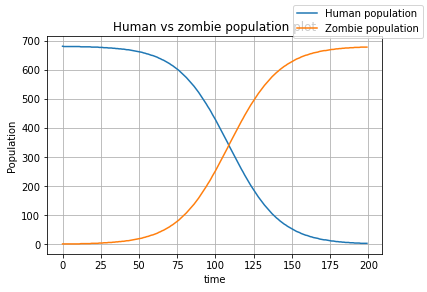

In [269]:
#Conditions
N = 683
beta = 0.06
dt = 0.01
Z_0 = 1
S_0 = N - Z_0
S_Z_vec_0 = (S_0,Z_0)


def human_consentration(S_0, t):
    """ Function that returns number of humans at a given time (given size, beta parameter and population. Rounds of value using numpy.astype(int)"""
    return np.array((S_0 + Z_0)*(S_0/Z_0)*np.exp(-beta*t)/(1+ (S_0/Z_0)*np.exp(-beta*t))).astype(int)


def zombie_consentration(Z_0, t):
    """ Function that returns number of zombies at a given time (given size, beta parameter and population. Rounds of value using numpy.astype(int)"""
    return np.array((S_0 +Z_0)/(1+(S_0/Z_0)*np.exp(-beta*t))).astype(int)


t = np.arange(0,200)
human_out = human_consentration(S_0, t)
zombie_out =zombie_consentration(Z_0, t)

e2p3fig = plt.figure()
e2p3 = e2p3fig.add_subplot()
e2p3.plot(t, human_out, label = 'Human population')
e2p3.plot(t,zombie_out, label = 'Zombie population')
e2p3.set_xlabel('time')
e2p3.set_ylabel('Population')
e2p3fig.legend()
e2p3.set_title('Human vs zombie population plot')
e2p3.grid()



### Part 4

In [270]:
#Conditions
N = 683
beta = 0.06
max_t = 200
dt = 0.01
Z_0 = 1
S_0 = N - Z_0
S_Z_vec_0 = (S_0,Z_0)


#part 4
def dS_Z_vec(S_Z_vec,t):
    dS = (-beta/N)*S_Z_vec[0]*S_Z_vec[1]
    return np.array([dS, -dS]) #here we take advantage of the fact that dZ = -dS



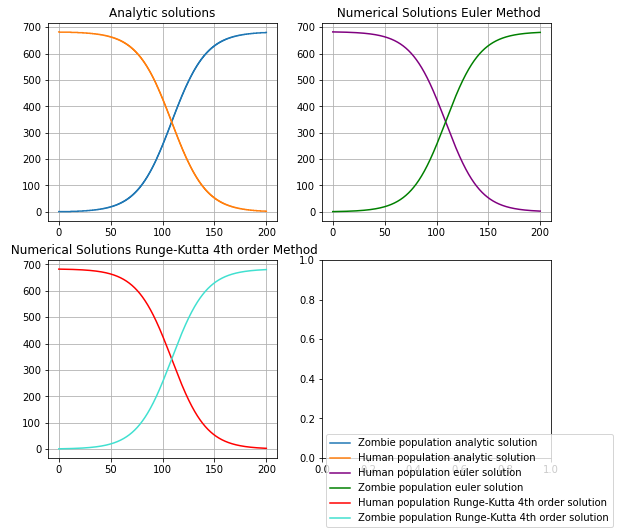

In [271]:

SZ_euler = ForwardEuler(dS_Z_vec, S_Z_vec_0, dt)
SZ_euler_sol =SZ_euler.solve(max_t)
SZ_runge = RungeKutta4(dS_Z_vec, S_Z_vec_0, dt)
SZ_runge_sol = SZ_runge.solve(max_t)



t = np.array([i*dt for i in range(1+int(max_t/dt))]) #Same t values as the solver, implemented here for plotting. Create plotter function in class?
human_analytic = human_consentration(S_0, t)
zombie_analytic = zombie_consentration(Z_0, t)



e2p4fig, e2p4ax = plt.subplots(2,2,figsize=(9,8))

e2p4ax[0,0].plot(t, zombie_analytic, label = 'Zombie population analytic solution')
e2p4ax[0,0].plot(t, human_analytic, label = 'Human population analytic solution')
e2p4ax[0,0].set_title('Analytic solutions')
e2p4ax[0,0].grid()



e2p4ax[0,1].plot(t, SZ_euler_sol[1][:,0], label = 'Human population euler solution', color = 'purple')
e2p4ax[0,1].plot(t, SZ_euler_sol[1][:,1], label = 'Zombie population euler solution', color = 'green' )
e2p4ax[0,1].set_title(' Numerical Solutions Euler Method')
e2p4ax[0,1].grid()

e2p4ax[1,0].plot(t, SZ_runge_sol[1][:,0], label = 'Human population Runge-Kutta 4th order solution', color = 'red')
e2p4ax[1,0].plot(t, SZ_runge_sol[1][:,1], label = 'Zombie population Runge-Kutta 4th order solution', color = 'turquoise' )
e2p4ax[1,0].set_title(' Numerical Solutions Runge-Kutta 4th order Method')
e2p4ax[1,0].grid()

e2p4fig.legend(loc ='lower right')




Part 5


First we calculate the numerical value for: 

$$ \lambda = -\frac{1}{T} \cdot \mathrm{ln} (0.6)$$

when
$$ T_{Sokndal} = 48 h $$
and 
$$ T_{Dirdal} = 72 h$$

In [10]:
lambda_sogndal = -np.log(0.6)*(48)**(-1)
lambda_dirdal = -np.log(0.6)*(72)**(-1)

print('Lambda rate for Sogndal =' ,lambda_sogndal, 'Rate value for Dirdal = ', lambda_dirdal)

Lambda rate for Sogndal = 0.010642200495124807 Rate value for Dirdal =  0.007094800330083204


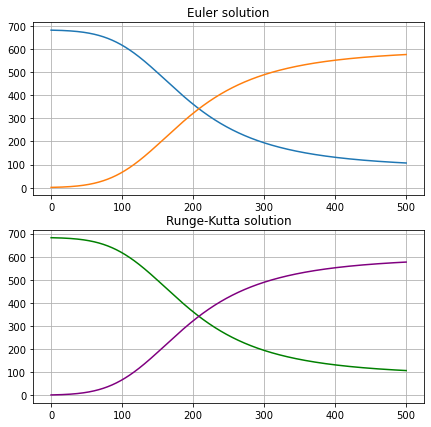

In [11]:
#Setup conditions (AGAIN)
#Conditions
N = 683
max_t = 500
dt = 0.01
Z_0 = 1
S_0 = N - Z_0
SZ_vec0 = (S_0,Z_0)
beta_0 = 0.06
lambda_rate = lambda_dirdal


t = np.array([i*dt for i in range(1+int(max_t/dt))])

def neo_dSZ(SZ_vec, t):
    """ New d(S,Z)/dt vector function, with new beta-function"""
    beta = beta_0*np.exp(-t*lambda_rate)
    dS = (-beta/N)*SZ_vec[0]*SZ_vec[1]
    return np.array([dS, -dS])

neo_euler = ForwardEuler(neo_dSZ,SZ_vec0, dt)
neo_euler_sol = neo_euler.solve(max_t)[1]
neo_runge = RungeKutta4(neo_dSZ, SZ_vec0, dt)
neo_runge_sol = neo_runge.solve(max_t)[1]

#PLOTTING
e2p5fig, p5ax = plt.subplots(2,1, figsize = (7,7))
p5ax[0].plot(t, neo_euler_sol[:,0])
p5ax[0].plot(t,neo_euler_sol[:,1])
p5ax[0].grid()
p5ax[0].set_title('Euler solution')
p5ax[1].plot(t,neo_runge_sol[:,0], color ='green')
p5ax[1].plot(t,neo_runge_sol[:,1], color ='purple')
p5ax[1].set_title('Runge-Kutta solution')
p5ax[1].grid()

## Exercise 3 Counter Strike 
note: (actual counter strike, not the videogame series)

### The SEZR- model:
$$
\begin{align}

\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)Z(t)}{N} \,, \\ 

\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)Z(t)}{N}-\sigma\cdot{E(t)} \,, \\ 

\frac{\mathrm{d}Z(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,, \\ 

\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= \left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

Where: $S$ and $Z$ as before refer to the human and zombie population, while $E$ and $R$ denotes number of exposed humans, and number of deceased zombies respectively.


We  define the attack function $\omega$:
$$
\begin{equation}
\omega(t) = a\displaystyle\sum_{i=1}^m
\exp\left(-\frac{1}{2}(\frac{t-T_i}{T_\sigma})^2\right)\,,
\end{equation}
$$

Where 
where $ a $ and $T_{\sigma}$ are constant parameters, and where
$T_1, T_2, \ldots, T_m$ are the times at which the humans launch
violent attacks.


We also define the basic reproduction number $\mathcal{R}$ as the average rate of new infected in a population.
For the SEZR-model, a good approximation to this number can be expressed as: 
$$
\begin{equation}
\tag{20}
\mathcal{R}_0\simeq\frac{\beta(t)}{\alpha + \omega(t)}.
\end{equation}
$$


### Part 1

We implement the attack funciton in python:


In [12]:
#Setup conditions (AGAIN, how many more times? Led zeppelin )

max_t = 200
a = 40*beta_0
T_sigma = 1
T_vec = np.array([0.1, 1.0,15, 50])
t = np.array([i*dt for i in range(1+int(max_t/dt))]) 

def omega(t):
    """function that calculates attack function of t"""     
    val = 0
    for i in T_vec:
         val += a*np.exp(-0.5*((t- i)/T_sigma)**2)
    return val

omegas = omega(t)



Plotting attack function with $ a = 40 \cdot \beta_0$ and $T_{\sigma} = 1$. We also create an array of $T$ attack-time values. 
We can see that the aptly named $T_{\sigma}$ value sets the standard deviation for these bell-curves, which logically would correpåsond to the effectivenes of the attack, the steeper the bell-curve, the quicker the attack takes effect. $a$, denotes the size of the attack,? (the value at $\omega(t = T_i) = a$)  

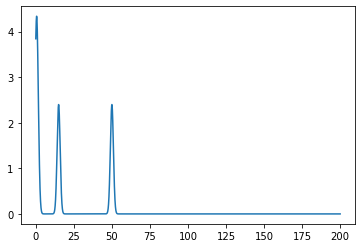

In [13]:
e3p1fig, e3p1ax = plt.subplots()
e3p1ax.plot(t,omegas)

We can see that the function is a sort of sum of gaussian bell curves, which makes sense considering the attack formula. We can see that these curves peak at the values where $t = T_i$. 

Part 2

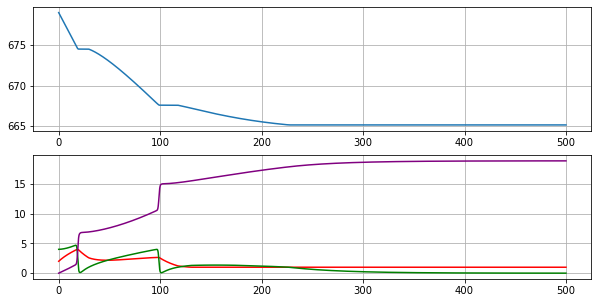

In [15]:
T_vec = np.array([20, 100])
t = np.array([i*dt for i in range(1+int(max_t/dt))])


Z0 = 4
S0 = N - Z0
E0 = 2
R0 = 0
SEZR_vec_0 = (S0,E0,Z0,R0)
N = 683
max_t = 500
dt = 0.1
beta_0 = 0.06
lambda_rate = lambda_dirdal


def dSEZR(SEZR_vec, t):
    """ New d(S,E,Z,R)/dt vector function, with new beta-function"""
   #### SETUP  
    if SEZR_vec[2] >= 1:
        beta = beta_0*np.exp(-t*lambda_rate) 
    else:
        beta = 0

    if SEZR_vec[1] >= 1:
        sigma = 1/24
    else:
        sigma = 0
    
    T_sigma = 1
    alpha = 0.02
    om = omega(t)
    a = 40*beta_0

    dS = (-beta/N)*SEZR_vec[0]*SEZR_vec[2]
    dE = (beta/N)*SEZR_vec[0]*SEZR_vec[2] - sigma*SEZR_vec[1]
    dZ = sigma*SEZR_vec[1] - (alpha + om)*(N**(-1))*SEZR_vec[0]*SEZR_vec[2]
    dR = (alpha + om)*(N**(-1))*SEZR_vec[0]*SEZR_vec[2]
    return np.array([dS,dE,dZ,dR])

attempt = RungeKutta4(dSEZR, SEZR_vec_0, dt)
attempt_sol = attempt.solve(max_t)[1]
#print(attempt_sol[:,3])

e3p2fig, e3p2ax = plt.subplots(2, figsize = (10,5))
e3p2ax[0].plot(t, attempt_sol[:,0], )
e3p2ax[0].grid()
e3p2ax[1].plot(t, attempt_sol[:,1], color = 'red')
e3p2ax[1].plot(t, attempt_sol[:,2], color = 'green')
e3p2ax[1].plot(t, attempt_sol[:,3], color = 'purple')
e3p2ax[1].grid()


We se that when $\frac{\beta}{\alpha} >1$ it is still possible to survive. Par example: When we have $\alpha = 0.02$ and $\beta = 0.06$ and hence a ratio of $\frac{\beta}{\alpha} = 3$ the number of non-infected humans stabilizes at roughly 600 people (for Dirdal). 

We can see that when turning on the violent attack function: We obtain interspersed periods of rapid decline in zombie populaiton at the time points where the attacks occur (WHich is makes sence as this is what a voilent attack towards the zombie populaiton entices)

3.0


## Exercise 4 Compartment model for Covid-19

### The SEIRD-model.

$$
\begin{align}
\tag{}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)I(t)}{N} \,, \\ 
\tag{}
\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)I(t)}{N}-\sigma\cdot{E(t)} \,, \\ 
\tag{}
\frac{\mathrm{d}I(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\gamma\cdot I(t) \,, \\ 
\tag{}
\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= (1-f)\cdot\gamma\cdot I(t) \,, \\ 
\tag{}
\frac{\mathrm{d}D(t)}{\mathrm{d}t} &= f\cdot\gamma\cdot I(t)\,.
\end{align}
$$



### Part 1

#### a)

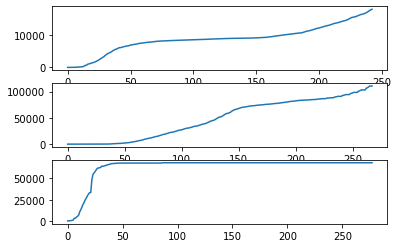

In [4]:
covidfile = pd.read_csv('data\corona_data.dat', sep ='\t')

Norway_data = covidfile.loc[covidfile['LOCATION'] == 'Norway']
Sweden_data = covidfile.loc[covidfile['LOCATION'] == 'Sweden']
Hubei_data = covidfile.loc[covidfile['LOCATION'] == 'Hubei']

covid_dta_fig, cov_ax = plt.subplots(3,1)
cov_ax[0].plot(Norway_data['ELAPSED_TIME_SINCE_OUTBREAK'],Norway_data['CONFIRMED'])
cov_ax[1].plot(Sweden_data['ELAPSED_TIME_SINCE_OUTBREAK'],Sweden_data['CONFIRMED'])
cov_ax[2].plot(Hubei_data['ELAPSED_TIME_SINCE_OUTBREAK'],Hubei_data['CONFIRMED'])

In [74]:
Norway_data

,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED
30058,Norway,2020-02-26 23:59:00,0,1,0,0
30059,Norway,2020-02-27 23:59:00,1,1,0,0
30060,Norway,2020-02-28 23:59:00,2,6,0,0
30061,Norway,2020-02-29 23:59:00,3,15,0,0
30062,Norway,2020-03-01 23:59:00,4,19,0,0
...,...,...,...,...,...,...
30296,Norway,2020-10-21 23:59:00,238,16964,279,11863
30297,Norway,2020-10-22 23:59:00,239,17234,279,11863
30298,Norway,2020-10-23 23:59:00,240,17532,279,11863
30299,Norway,2020-10-24 23:59:00,241,17749,279,11863


### Part 2



In [71]:
#Weird approach where we fit the derivatives to the gradient of the data

sigma = 1/5.1
gamma = 1/20
death_rate = 0.05

N = 58.5e6


def data_comb(Data, Orig_population):
    """function that retrieves relevant data from the file, given the Original population of the location the input data describes"""
    time_data = Data['ELAPSED_TIME_SINCE_OUTBREAK']
    S_data = Orig_population - Data['CONFIRMED']  #-Data['RECOVERED'] - Data['DEATHS'] #Assume that the number of "Susceptible " is equall to population - confirmed cases e.g: no re-infection
    I_data = Data['CONFIRMED'] - Data['RECOVERED'] - Data['DEATHS']
    R_data = Data['RECOVERED']
    D_data = Data['DEATHS']

    #E data not directly obtainable from the other data, but derivative can be estimated (see gradient_function)
    return(time_data,S_data,I_data,R_data,D_data)

def data_gradient(combed_data):
    """Function that retrieves the "discrete" derivatives between the datapoints """    
    time_data = combed_data[0]
    dS_data = np.gradient(combed_data[1],time_data)
    dI_data = np.gradient(combed_data[2],time_data) 
    dR_data = np.gradient(combed_data[3],time_data)
    dD_data = np.gradient(combed_data[4], time_data)
    #
    dE_data = -dS_data - dI_data - sigma*combed_data[2] #Estm, dE from the other derivatives: assuming that the model is viable and sigma = 1/5.1
    # 
    return(time_data, dS_data,dE_data,dI_data,dR_data,dD_data)


def dSEIRD(data, beta0, lambda_par):
    """function that takes in "filtered/combed" data, and returns derivatives of the SEIRD model """
    t = np.array(data[0])
    beta = beta0*np.exp(-lambda_par*t)
    SEIRD_vec = data[1:]
    dS = (-beta/N)*SEIRD_vec[0]*SEIRD_vec[2]
    dE = (beta/N)*SEIRD_vec[0]*SEIRD_vec[2] - sigma*SEIRD_vec[1] 
    dI = sigma*SEIRD_vec[1] - gamma*SEIRD_vec[2]
    dR = (1- death_rate)*gamma*SEIRD_vec[2]
    dD = death_rate*gamma*SEIRD_vec[2]

    return np.array([dS,dE,dI,dR,dD]).flatten()           


data_combed = data_comb(Sweden_data, Orig_population = N)
derivative_data = data_gradient(data_combed)

popt, dev = opt.curve_fit(dSEIRD,data_combed,np.array([derivative_data[1],derivative_data[2],derivative_data[3],derivative_data[4],derivative_data[5]]).flatten()) #is weird because of testing

popt




array([1., 1.])

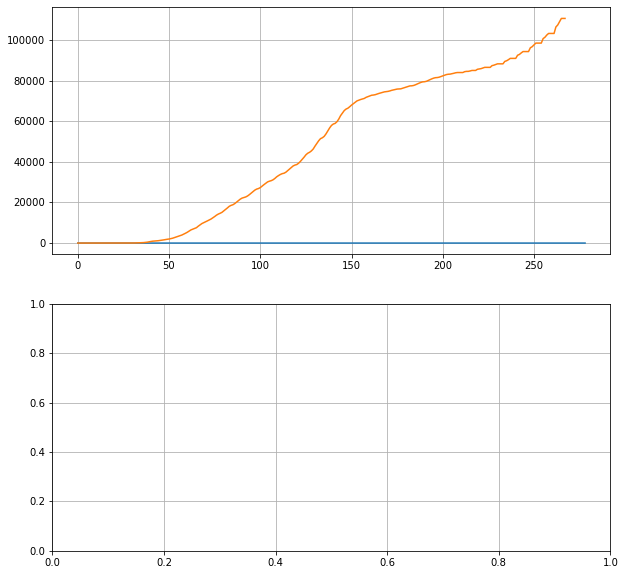

In [74]:
def dSEIRD_weird(y, t):
    """function that takes in "filtered/combed" data, and returns derivatives of the SEIRD model """
    N = 58.5e6
    lambda_par = popt[1]
    beta0 = popt[0]
    sigma = 1/5.1
    gamma = 1/20
    death_rate = 0.05
    
    beta = beta0*np.exp(- t*lambda_par)
    
    dS = -(beta/N)*y[0]*y[2]
    dE = - dS - sigma*y[1] 
    dI = sigma*y[1] - gamma*y[2]
    dR = (1- death_rate)*gamma*y[2]
    dD = death_rate*gamma*y[2]

    return np.array([dS,dE,dI,dR,dD])


dt = 0.1
maxtime = 278
S0 = 58e6-1
E0 = 0
I0 = 1
R0 = 0
D0 = 0
y0 = np.array([S0,E0,I0,R0,D0])

lets_try_again = RungeKutta4(dSEIRD_weird,y0, dt)
trying = lets_try_again.solve(maxtime)

tiredof, thisshit = plt.subplots(2, figsize=(10,10))
thisshit[0].plot(trying[0], trying[1][:,1]+trying[1][:,2]+trying[1][:,3] +trying[1][:,4])
thisshit[0].grid()
thisshit[0].plot(data_combed[0], data_combed[2]+data_combed[3]+data_combed[4])
thisshit[1].grid()



In [201]:
### approach where we fit the solved system of equations to the data
def data_wrangler(Data, N):
    """function that retrieves relevant data from the file, given the Original population of the location the input data describes"""
    time_data = Data['ELAPSED_TIME_SINCE_OUTBREAK'].to_numpy()
    S_data =N - Data['CONFIRMED']  # #Assume that the number of "Susceptible " is equall to population - confirmed cases e.g: no re-infection
    I_data = Data['CONFIRMED'] - Data['RECOVERED'] - Data['DEATHS']
    R_data = Data['RECOVERED']
    D_data = Data['DEATHS']
    return np.array([N, time_data,S_data,I_data,R_data,D_data])


def function_to_be_fitted(wrangeled_data,b_0, lam_pa):
    """Function that "takes in data" and outputs a numerical solution instance of the SEIRD model, note that 
    the class solver generates its own x(t/input) values, and we do not use the data as direct input to ythe solution. This solution will then only work 
    if the x (t) values are evenly spaced in the data """
    max_t = len(wrangeled_data[1])
    dt = wrangeled_data[1][1] - wrangeled_data[1][0]           #Assumes dt is equall to first timestep
    
    s0 = wrangeled_data[0] -1
    e0,i0,r0,d0 =0,1,0,0
    y0 =(s0,e0,i0,r0,d0)

    seird_instance = SEIRD(N=58.5e6, sigma=1/5.1, gamma = 1/20, death_rate =0.05).dSEIRD_setup(b_0,lam_pa)

    runge_instance =RungeKutta4(seird_instance, y0, dt)
    instance_sol = runge_instance.solve(max_t)
    return np.array(instance_sol[1][:,2:])
    

N = 5.85e7       #Current Hubei population acording to wikipedia
test_wrangeled = data_wrangler(Hubei_data,N)
function_to_be_fitted(test_wrangeled,15.75,0.27)

popt, devs = opt.curve_fit(function_to_be_fitted,test_wrangeled, np.array([test_wrangeled[3],test_wrangeled[4],test_wrangeled[5]]).flatten())

ValueError: setting an array element with a sequence.